In [1]:
'''
24年9月末，用PointNet++重启牙齿预备体轮廓线自动检测课题。
此算法相较3D-Unet的优势在于内存占用小，并且轮廓线不带锯齿。
初步流程：
1.对标准完整牙进行姿态调整；
2.对所有牙齿预备体（相对已经完成姿态调整的标准完整牙）执行配准；
3.对牙齿预备体进行多分类数据预处理；
4.PointNet++语义分割模型；
5.轮廓线重建。
'''

'\n24年9月末，用PointNet++重启牙齿预备体轮廓线自动检测课题。\n此算法相较3D-Unet的优势在于内存占用小，并且轮廓线不带锯齿。\n初步流程：\n1.对标准完整牙进行姿态调整；\n2.对所有牙齿预备体（相对已经完成姿态调整的标准完整牙）执行配准；\n3.对牙齿预备体进行多分类数据预处理；\n4.PointNet++语义分割模型；\n5.轮廓线重建。\n'

In [2]:
'''
1.姿态调整：以舌侧为x轴正向，以牙冠方向为y轴正向，z轴为近远中取向，其正向由右手定则确定。
'''

import chardet
import numpy as np


def detect_encoding(file_path):
    '''检测文件的encoding方式'''
    with open(file_path, 'rb') as file:
        raw_data = file.read()
        result = chardet.detect(raw_data)
        return result['encoding']
        
def load_obj_file(file_path, encoding):
    '''读取obj文件中的点云坐标，输出是list'''
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return vertices, faces
    
def center_vertices(vertices):
    '''将点云坐标系原点移动至其包围盒中心，输出是array'''
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices


In [3]:
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


def compute_bounding_box(points):
    """计算点云的包围盒"""
    min_point = np.min(points, axis=0)
    max_point = np.max(points, axis=0)
    bbox_size = max_point - min_point
    bbox_center = (min_point + max_point) / 2.0
    return bbox_size, bbox_center

def extract_top_subcloud(points, bbox_size, bbox_center, height=4.0):
    """提取y坐标在ymax到ymax-3范围内的子点云"""
    min_y = bbox_center[1] + bbox_size[1] / 2.0 - height
    top_subcloud = points[points[:, 1] >= min_y]
    return top_subcloud

def find_best_rotation(points, axis1, axis2, axis3, half_angle_range=int(90), angle_step=1):
    """绕axis1旋转，使得axis2（优先）、axis3方向包围盒尺寸最小，输出旋转矩阵"""
    min_size2 = float('inf')
    min_size3 = float('inf')
    best_rotation_matrix = None

    for angle in np.arange(-half_angle_range, half_angle_range, angle_step):
        # 绕指定轴旋转
        rotation_matrix = R.from_euler(axis1, angle, degrees=True).as_matrix()
        rotated_points = points.dot(rotation_matrix.T)
        
        # 计算包围盒尺寸
        bbox_size, _ = compute_bounding_box(rotated_points)
        
        # 找出目标轴之外的最小尺寸
        if axis2 == 'x':
            size2 = bbox_size[0]  # x方向宽度
        elif axis2 == 'y':
            size2 = bbox_size[1]  # z方向宽度
        elif axis2 == 'z':
            size2 = bbox_size[2]  # z方向宽度

        # 找出目标轴之外的最小尺寸
        if axis3 == 'x':
            size3 = bbox_size[0]  # x方向宽度
        elif axis3 == 'y':
            size3 = bbox_size[1]  # z方向宽度
        elif axis3 == 'z':
            size3 = bbox_size[2]  # z方向宽度

        # 如果当前尺寸比之前的最小尺寸还小，则更新
        if size2 < min_size2:
            min_size2 = size2
            min_size3 = size3
            best_rotation_matrix = rotation_matrix
        elif size2 == min_size2:
            if size3 <min_size3:
                min_size3 = size3
                best_rotation_matrix = rotation_matrix

    return best_rotation_matrix

def flatten_and_analyze_curve(points, z_threshold=0.3, y_offset=1.5):
    """在新x-y平面上分析曲线的曲率，并确定x、z方向。
    
    参数:
    - points: 点云数据，形状为 (n, 3)
    - z_threshold: 用于滤波的z坐标阈值
    - y_offset: 确定用于分裂曲线的横线 y=ymax-y_offset 的偏移量
    """
    # 提取平面内的点
    flat_points = points[np.abs(points[:, 2]) <= z_threshold]

    # 提取 x 和 y 坐标
    x_coords = flat_points[:, 0]
    y_coords = flat_points[:, 1]

    # 对 x_coords 和 y_coords 进行排序以确保 x_coords 严格递增
    sorted_indices = np.argsort(x_coords)
    x_coords = x_coords[sorted_indices]
    y_coords = y_coords[sorted_indices]

    # 确定 ymax - y_offset 这条横线
    ymax = np.max(y_coords)
    y_threshold = ymax - y_offset

    # 找到 y_coords 刚刚超过 y_threshold 的最小和最大索引
    above_threshold_indices = np.where(y_coords > y_threshold)[0]
    if len(above_threshold_indices) == 0:
        raise ValueError("没有点的y坐标超过指定的y_threshold")

    min_index = above_threshold_indices[0]
    max_index = above_threshold_indices[-1]

    # 使用这些索引作为左侧和右侧的分界点
    left_indices = np.where((y_coords <= y_threshold) & (x_coords <= x_coords[min_index]))[0]
    right_indices = np.where((y_coords <= y_threshold) & (x_coords >= x_coords[max_index]))[0]

    left_index = left_indices[np.argmin(np.abs(y_coords[left_indices] - y_threshold))]
    right_index = right_indices[np.argmin(np.abs(y_coords[right_indices] - y_threshold))]

    x2_left, y2_left = x_coords[left_index], y_coords[left_index]
    x2_right, y2_right = x_coords[right_index], y_coords[right_index]

    # 找到曲线的第一个点和最后一个点
    x1, y1 = x_coords[0], y_coords[0]
    x3, y3 = x_coords[-1], y_coords[-1]

    # 计算线段 (x1, y1)-(x2_left, y2_left) 和 (x2_right, y2_right)-(x3, y3) 的斜率
    slope_left = (y2_left - y1) / (x2_left - x1)
    slope_right = (y3 - y2_right) / (x3 - x2_right)

    # 计算两侧线段下方的点数占比
    left_side_points = flat_points[flat_points[:, 0] < x2_left]
    right_side_points = flat_points[flat_points[:, 0] >= x2_right]

    left_under_line = left_side_points[:, 1] < (slope_left * (left_side_points[:, 0] - x1) + y1)
    right_under_line = right_side_points[:, 1] < (slope_right * (right_side_points[:, 0] - x2_right) + y2_right)

    left_under_ratio = np.sum(left_under_line) / len(left_side_points)
    right_under_ratio = np.sum(right_under_line) / len(right_side_points)

    # 确定 x 方向：下凹一侧为 x 正方向
    x_direction = -1 if left_under_ratio > right_under_ratio else 1

    # 复制相同的旋转给 z 方向以保持手性
    z_direction = x_direction

    return x_direction, z_direction

def align_point_cloud(points):
    """处理并旋转点云"""  
    # 计算原始点云的包围盒
    bbox_size, bbox_center = compute_bounding_box(points)

    # 提取顶端子点云1：较短，用于找到最扁取向
    top_subcloud1 = extract_top_subcloud(points, bbox_size, bbox_center, height=3.0)

    # 找到使得点云最扁的旋转角度
    best_rotation_matrix = find_best_rotation(top_subcloud1, 'y', 'x', 'z')

    # 提取顶端子点云2：较长，用于对比唇舌侧的凸性
    top_subcloud2 = extract_top_subcloud(points, bbox_size, bbox_center, height=5.0)
    
    # 将子点云旋转到最佳角度
    rotated_subcloud = top_subcloud2.dot(best_rotation_matrix.T)
    
    # 在新x-y平面上分析曲线并确定x轴方向
    x_direction, z_direction = flatten_and_analyze_curve(rotated_subcloud)

    # 确定最终旋转矩阵
    new_x_axis = best_rotation_matrix[:, 0] * x_direction
    new_y_axis = best_rotation_matrix[:, 1]
    new_z_axis = best_rotation_matrix[:, 2] * z_direction

    best_rotation_matrix_y = np.column_stack((new_x_axis, new_y_axis, new_z_axis))

    # 旋转整个原始点云到新的坐标系
    aligned_points = points.dot(best_rotation_matrix_y.T)

    # 在z轴上进行进一步优化旋转
    best_rotation_matrix_z = find_best_rotation(aligned_points, 'z', 'x', 'y', half_angle_range=int(30))
    aligned_points = aligned_points.dot(best_rotation_matrix_z.T)

    # 在x轴上进行进一步优化旋转
    best_rotation_matrix_x = find_best_rotation(aligned_points, 'x', 'z', 'y', half_angle_range=int(30))
    aligned_points = aligned_points.dot(best_rotation_matrix_x.T)

    # 最终的旋转矩阵
    final_rotation_matrix = best_rotation_matrix_y.T.dot(best_rotation_matrix_z.T).dot(best_rotation_matrix_x.T)

    return aligned_points, final_rotation_matrix

# 创建一个两行一列的子图布局
def plot_cloud_before_and_after_pose_adjustment(points, y_rotation_angle=0):
    """绘制结果"""
    aligned_points, _ = align_point_cloud(points)
    
    # 绘图
    fig = plt.figure(figsize=(14, 7))

    # 在第一个子图中显示原始点云
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='.')
    # 旋转视角，将y轴竖直并绕y轴旋转
    ax1.view_init(elev=90, azim=y_rotation_angle)
    # 设置图例
    ax1.set_title('Original Point Cloud')
    ax1.set_xlabel('X axis')
    ax1.set_ylabel('Y axis')
    ax1.set_zlabel('Z axis')

    # 保持原始点云各轴比例一致
    max_range = np.array([points[:, 0].max() - points[:, 0].min(),
                          points[:, 1].max() - points[:, 1].min(),
                          points[:, 2].max() - points[:, 2].min()]).max() / 2.0

    mid_x = (points[:, 0].max() + points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max() + points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max() + points[:, 2].min()) * 0.5

    ax1.set_xlim(mid_x - max_range, mid_x + max_range)
    ax1.set_ylim(mid_y - max_range, mid_y + max_range)
    ax1.set_zlim(mid_z - max_range, mid_z + max_range)

    # 在第二个子图中显示对齐后的点云
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(aligned_points[:, 0], aligned_points[:, 1], aligned_points[:, 2], c='r', marker='.')
    # 旋转视角，将y轴竖直并绕y轴旋转
    ax2.view_init(elev=90, azim=y_rotation_angle)
    # 设置图例
    ax2.set_title('Aligned Point Cloud')
    ax2.set_xlabel('X axis')
    ax2.set_ylabel('Y axis')
    ax2.set_zlabel('Z axis')

    # 设置对齐后的点云的坐标轴范围，使得每个轴的单位长度相同
    max_range_aligned = np.array([aligned_points[:, 0].max() - aligned_points[:, 0].min(),
                                  aligned_points[:, 1].max() - aligned_points[:, 1].min(),
                                  aligned_points[:, 2].max() - aligned_points[:, 2].min()]).max() / 2.0

    mid_x_aligned = (aligned_points[:, 0].max() + aligned_points[:, 0].min()) * 0.5
    mid_y_aligned = (aligned_points[:, 1].max() + aligned_points[:, 1].min()) * 0.5
    mid_z_aligned = (aligned_points[:, 2].max() + aligned_points[:, 2].min()) * 0.5

    ax2.set_xlim(mid_x_aligned - max_range_aligned, mid_x_aligned + max_range_aligned)
    ax2.set_ylim(mid_y_aligned - max_range_aligned, mid_y_aligned + max_range_aligned)
    ax2.set_zlim(mid_z_aligned - max_range_aligned, mid_z_aligned + max_range_aligned)

    plt.show()

当前工作目录： C:\Users\HP
修改后的工作目录： D:\李娅宁\9月下旬项目重开


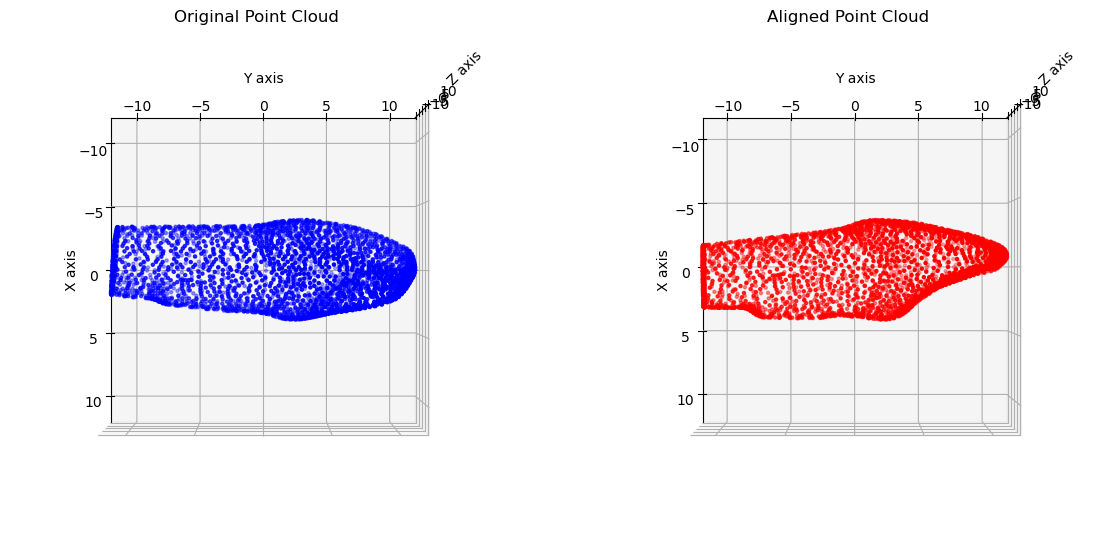

In [4]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/9月下旬项目重开"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())

# 设置输入文件路径
obj_file_path = "标准牙/原始牙.obj"

# 读取点云坐标并中心化
obj_encoding = detect_encoding(obj_file_path)
obj_vertices, obj_faces = load_obj_file(obj_file_path, obj_encoding)
centered_vertices = center_vertices(obj_vertices)

# 姿态调整
aligned_points, final_rotation_matrix = align_point_cloud(centered_vertices)

# 对比姿态调整前后的点云
plot_cloud_before_and_after_pose_adjustment(centered_vertices)

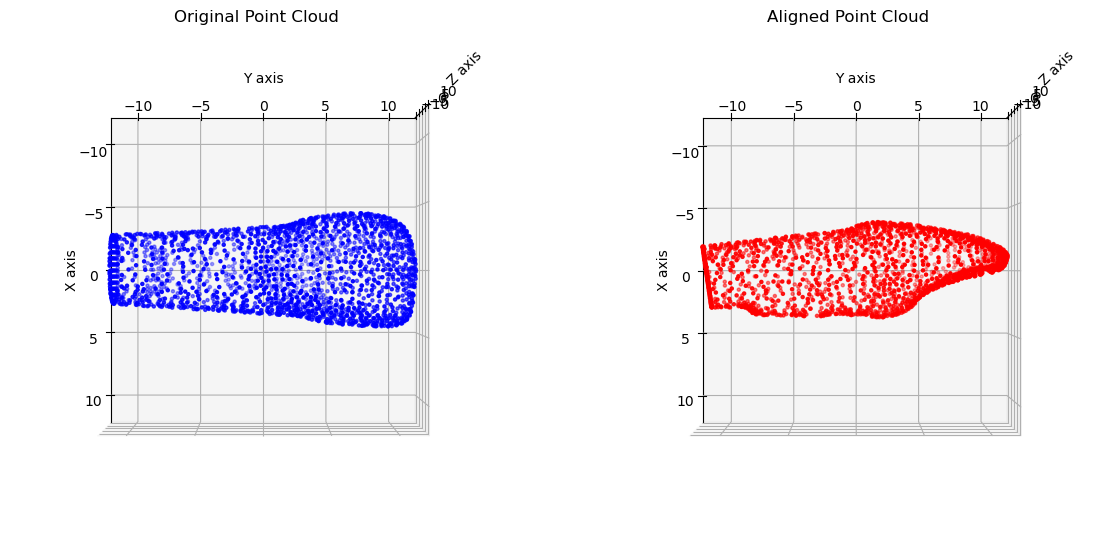

In [5]:
'''
2.配准
目前北航用的算法是ICP，共同区域通过加密来增加权重
'''

# 读一颗预备体点云，并执行姿态调整
prep_file_path = "标准牙/原始牙0928.obj"
prep_encoding = detect_encoding(prep_file_path)
prep_vertices, prep_faces = load_obj_file(prep_file_path, prep_encoding)
prep_centered_vertices = center_vertices(prep_vertices)
prep_aligned_points, prep_final_rotation_matrix = align_point_cloud(prep_centered_vertices)
plot_cloud_before_and_after_pose_adjustment(prep_centered_vertices)

In [6]:
import numpy as np
import open3d as o3d


source_points = prep_aligned_points  # 待配准点云
target_points = aligned_points  # 标准点云

# 转换为Open3D点云格式
source_pcd = o3d.geometry.PointCloud()
source_pcd.points = o3d.utility.Vector3dVector(source_points)

target_pcd = o3d.geometry.PointCloud()
target_pcd.points = o3d.utility.Vector3dVector(target_points)

# 计算法向量（可选）
source_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# 可视化初始点云
o3d.visualization.draw_geometries([source_pcd, target_pcd], window_name="Before ICP", width=800, height=600)

# 使用 KDTree 进行重叠区域检测
kdtree_target = o3d.geometry.KDTreeFlann(target_pcd)

# 设定一个阈值来检测重叠
overlap_threshold = 0.5  # 根据实际情况调整此值
overlap_points = []

# 仅检测 y 轴在负半轴的重叠点
for point in source_points:
    if point[1] < 0:  # 只检测 y 轴负半轴上的点
        [_, idx, _] = kdtree_target.search_radius_vector_3d(point, overlap_threshold)
        if len(idx) > 0:
            overlap_points.append(point)

# 转换为点云格式
overlap_pcd = o3d.geometry.PointCloud()
overlap_pcd.points = o3d.utility.Vector3dVector(overlap_points)

# 可视化重叠区域
o3d.visualization.draw_geometries([overlap_pcd], window_name="Filtered Overlap Points", width=800, height=600)

# 检查是否有重叠点
if len(overlap_points) > 0:
    # 执行 ICP 配准
    overlap_pcd = o3d.geometry.PointCloud()
    overlap_pcd.points = o3d.utility.Vector3dVector(overlap_points)

    # 设置 ICP 参数
    threshold = 0.5  # 最大对应点距离阈值，可以根据实际情况调整
    initial_transformation = np.eye(4)  # 初始变换矩阵

    # 执行点到点 ICP 配准
    print("Applying ICP...")
    reg_p2p = o3d.pipelines.registration.registration_icp(
        overlap_pcd, target_pcd, threshold, initial_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())

    # 输出配准信息和转换矩阵
    print("ICP has converged:", reg_p2p.inlier_rmse < threshold)  # 使用均方根误差来判断收敛
    print("Fitness (overlap):", reg_p2p.fitness)  # 表示重叠部分的比例
    print("Transformation matrix:")
    print(reg_p2p.transformation)

    # 将源点云应用变换矩阵进行配准
    source_pcd.transform(reg_p2p.transformation)

    # 可视化配准后的点云
    o3d.visualization.draw_geometries([source_pcd, target_pcd], window_name="After ICP", width=800, height=600)
else:
    print("No overlapping points detected, ICP cannot be applied.")


Applying ICP...
ICP has converged: True
Fitness (overlap): 0.9971830985915493
Transformation matrix:
[[ 0.99337559  0.00517179  0.11479629  0.24646212]
 [-0.00875734  0.99948869  0.03075172  0.03880979]
 [-0.11457855 -0.03155332  0.99291296 -0.51622051]
 [ 0.          0.          0.          1.        ]]


In [7]:
import numpy as np
import open3d as o3d


source_points = prep_aligned_points  # 待配准点云
target_points = aligned_points  # 标准点云

# 转换为Open3D点云格式
source_pcd = o3d.geometry.PointCloud()
source_pcd.points = o3d.utility.Vector3dVector(source_points)

target_pcd = o3d.geometry.PointCloud()
target_pcd.points = o3d.utility.Vector3dVector(target_points)

# 计算法向量
print("Estimating normals for source and target point clouds...")

# 计算source和target点云的法向量
source_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# 可视化初始点云
o3d.visualization.draw_geometries([source_pcd, target_pcd], window_name="Before ICP", width=800, height=600)

# 使用 KDTree 进行重叠区域检测
kdtree_target = o3d.geometry.KDTreeFlann(target_pcd)

# 设定一个阈值来检测重叠
overlap_threshold = 0.5  # 你可以根据实际情况调整此值
overlap_points = []

# 仅检测在y轴负半轴且不在底面的点
for point in source_points:
    if point[1] < 0 and point[1] > np.min(source_points[:,1]) + 1:  # 只检测 y 轴负半轴上的点
        [_, idx, _] = kdtree_target.search_radius_vector_3d(point, overlap_threshold)
        if len(idx) > 0:
            overlap_points.append(point)

# 将重叠区域转换为Open3D点云
overlap_pcd = o3d.geometry.PointCloud()
overlap_pcd.points = o3d.utility.Vector3dVector(overlap_points)

# 计算重叠区域的法向量
print("Estimating normals for overlap region...")
overlap_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# 可视化重叠区域
o3d.visualization.draw_geometries([overlap_pcd], window_name="Filtered Overlap Points", width=800, height=600)

# 多尺度
thresholds = [2.0, 1.0, 0.5]  # 从粗到精的不同阈值
current_transformation = np.eye(4)

print("Applying Point-to-Plane ICP...")
for threshold in thresholds:
    # 点到面配准
    reg_p2plane = o3d.pipelines.registration.registration_icp(
        overlap_pcd, target_pcd, threshold, initial_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    # 输出配准信息和转换矩阵
    current_transformation = reg_p2plane.transformation
    print(f"ICP with threshold {threshold} has converged:", reg_p2plane.inlier_rmse < threshold)
    print("Fitness (overlap):", reg_p2plane.fitness)  # 表示重叠部分的比例，值越大重叠越好
    print("Inlier RMSE:", reg_p2plane.inlier_rmse)  # 表示点云之间的误差，值越小越好
    print("Transformation matrix:")
    print(reg_p2plane.transformation)

# 将最终的变换应用到源点云
source_pcd.transform(current_transformation)

# 可视化配准后的点云
o3d.visualization.draw_geometries([source_pcd, target_pcd], window_name="After ICP", width=800, height=600)


Estimating normals for source and target point clouds...
Estimating normals for overlap region...
Applying Point-to-Plane ICP...
ICP with threshold 2.0 has converged: True
Fitness (overlap): 1.0
Inlier RMSE: 0.27421811142595603
Transformation matrix:
[[ 0.98012226 -0.00207935 -0.19838352  0.0801358 ]
 [-0.00502911  0.99936335 -0.03532133  0.01723586]
 [ 0.19833067  0.03561691  0.97948782 -0.51775571]
 [ 0.          0.          0.          1.        ]]
ICP with threshold 1.0 has converged: True
Fitness (overlap): 1.0
Inlier RMSE: 0.274218111425956
Transformation matrix:
[[ 0.98012226 -0.00207935 -0.19838352  0.0801358 ]
 [-0.00502911  0.99936335 -0.03532133  0.01723586]
 [ 0.19833067  0.03561691  0.97948782 -0.51775571]
 [ 0.          0.          0.          1.        ]]
ICP with threshold 0.5 has converged: True
Fitness (overlap): 0.9917355371900827
Inlier RMSE: 0.2714660676694061
Transformation matrix:
[[ 0.97852505 -0.00213342 -0.20611691  0.08376028]
 [-0.00488178  0.99942611 -0.033

In [8]:
import numpy as np
import open3d as o3d


source_points = prep_aligned_points  # 待配准点云
target_points = aligned_points  # 标准点云

# 转换为Open3D点云格式
source_pcd = o3d.geometry.PointCloud()
source_pcd.points = o3d.utility.Vector3dVector(source_points)

target_pcd = o3d.geometry.PointCloud()
target_pcd.points = o3d.utility.Vector3dVector(target_points)

# 计算法向量
print("Estimating normals for source and target point clouds...")
source_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# 可视化初始点云
o3d.visualization.draw_geometries([source_pcd, target_pcd], window_name="Before ICP", width=800, height=600)

# 使用 KDTree 进行重叠区域检测
kdtree_target = o3d.geometry.KDTreeFlann(target_pcd)

# 设定一个阈值来检测重叠
overlap_threshold = 0.5  # 可以根据实际情况调整此值
overlap_points = []

# 仅检测在y轴负半轴且不在底面的点
for point in source_points:
    if point[1] < -1 and point[1] > np.min(source_points[:, 1]) + 2:  # 只检测 y 轴负半轴上的点
        [_, idx, _] = kdtree_target.search_radius_vector_3d(point, overlap_threshold)
        if len(idx) > 0:
            overlap_points.append(point)

# 将重叠区域转换为Open3D点云
overlap_pcd = o3d.geometry.PointCloud()
overlap_pcd.points = o3d.utility.Vector3dVector(overlap_points)

# 可视化重叠区域
o3d.visualization.draw_geometries([overlap_pcd], window_name="Filtered Overlap Points", width=800, height=600)

# 第一步：先对重叠区域进行ICP配准
threshold_overlap = 0.5
initial_transformation = np.eye(4)

print("Applying ICP to overlap region...")
reg_p2plane_overlap = o3d.pipelines.registration.registration_icp(
    overlap_pcd, target_pcd, threshold_overlap, initial_transformation,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())

print("Overlap ICP has converged:", reg_p2plane_overlap.inlier_rmse < threshold_overlap)
print("Fitness (overlap):", reg_p2plane_overlap.fitness)
print("Transformation matrix (overlap):")
print(reg_p2plane_overlap.transformation)

# 将初步的变换矩阵应用到源点云
source_pcd.transform(reg_p2plane_overlap.transformation)

# 第二步：对整个点云进行ICP配准
threshold_global = 1.0
print("Applying global ICP after overlap transformation...")
reg_p2plane_global = o3d.pipelines.registration.registration_icp(
    source_pcd, target_pcd, threshold_global, np.eye(4),
    o3d.pipelines.registration.TransformationEstimationPointToPlane())

print("Global ICP has converged:", reg_p2plane_global.inlier_rmse < threshold_global)
print("Fitness (global):", reg_p2plane_global.fitness)
print("Transformation matrix (global):")
print(reg_p2plane_global.transformation)

# 将全局ICP结果的变换矩阵应用到源点云
source_pcd.transform(reg_p2plane_global.transformation)

# 可视化配准后的点云
o3d.visualization.draw_geometries([source_pcd, target_pcd], window_name="After Global ICP", width=800, height=600)


Estimating normals for source and target point clouds...
Applying ICP to overlap region...
Overlap ICP has converged: True
Fitness (overlap): 0.9838709677419355
Transformation matrix (overlap):
[[ 9.93404418e-01 -1.98804006e-03 -1.14646022e-01  3.26794004e-02]
 [ 1.30759438e-04  9.99868676e-01 -1.62053767e-02  2.28434014e-03]
 [ 1.14663183e-01  1.60835017e-02  9.93274220e-01 -4.26229181e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Applying global ICP after overlap transformation...
Global ICP has converged: True
Fitness (global): 0.0
Transformation matrix (global):
[[ 9.99302009e-01 -1.02715291e-03 -3.73422045e-02 -1.59976321e+01]
 [-3.57477846e-04  9.99313203e-01 -3.70539398e-02 -5.51210168e-02]
 [ 3.73546181e-02  3.70414255e-02  9.98615324e-01 -1.38587242e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [9]:
# 妈的！数据里有屎！58


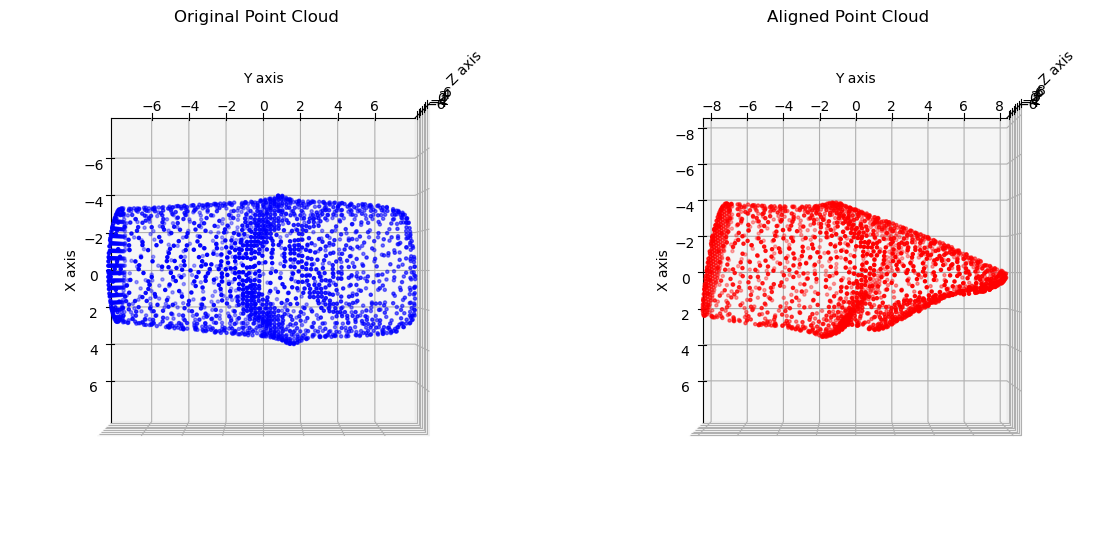

In [10]:
'''
3.多分类数据预处理
'''

# 设置输入文件路径，此处只是测试地址
obj_file_path = "150颗0806新数据/1.obj"
obj_encoding = detect_encoding(obj_file_path)
obj_vertices, obj_faces = load_obj_file(obj_file_path, obj_encoding)
centered_vertices = center_vertices(obj_vertices)
aligned_points, final_rotation_matrix = align_point_cloud(centered_vertices)
plot_cloud_before_and_after_pose_adjustment(centered_vertices)


In [11]:
'''
首先处理150颗的数据，每个预备体有一个obj文件、一个mark文件和一个csv文件
需要注意的是，marks2（也就是csv文件）是用姿态调整后的marks2处理得来的（处理流程并不在此脚本之中），因此为了保持一致性，前面的姿态调整函数的参数不可任意调整
'''

import networkx as nx
from scipy.interpolate import make_interp_spline

def load_mark_file(file_path, encoding):
    '''读取mark文件，对应marks1的数据'''
    marks = []
    try:
        with open(file_path, 'r', encoding=encoding) as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 3:
                    mark = [float(parts[0]), float(parts[1]), float(parts[2])]
                    marks.append(mark)
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except Exception as e:
        print(f"发生错误: {e}")
    return marks

def interpolate_spline(aligned_marks1):
    """
    对标记点进行样条插值，形成一个闭合曲线。点的顺序由极角排序确定。
    
    参数:
    aligned_marks1: 一个 Nx3 的数组，包含标记点的坐标。
    
    返回:
    spline_points: 插值后的点的坐标。
    """
    # 确保 aligned_marks1 是一个 numpy 数组
    aligned_marks1 = np.array(aligned_marks1)

    # 极角排序
    centered_aligned_marks1 = aligned_marks1 - np.mean(aligned_marks1)
    angles = np.arctan2(centered_aligned_marks1[:, 2], centered_aligned_marks1[:, 0])
    sorted_indices = np.argsort(angles)
    ordered_marks = aligned_marks1[sorted_indices]
    
    # 生成闭环
    closed_marks = np.vstack([ordered_marks, ordered_marks[0]])
    
    # 提取 x, y, z 坐标
    x = closed_marks[:, 0]
    y = closed_marks[:, 1]
    z = closed_marks[:, 2]
    
    # 生成参数 t
    t = np.linspace(0, 1, len(closed_marks))
    
    # 样条插值
    spline_x = make_interp_spline(t, x, k=3)
    spline_y = make_interp_spline(t, y, k=3)
    spline_z = make_interp_spline(t, z, k=3)
    
    # 生成更多的点
    t_new = np.linspace(0, 1, 101)  # 最后一个点会与起点重合，因此实际上是100个点
    spline_x_new = spline_x(t_new)
    spline_y_new = spline_y(t_new)
    spline_z_new = spline_z(t_new)
    
    # 合并第一个点以闭合曲线
    spline_x_new = np.concatenate([spline_x_new, [spline_x_new[0]]])
    spline_y_new = np.concatenate([spline_y_new, [spline_y_new[0]]])
    spline_z_new = np.concatenate([spline_z_new, [spline_z_new[0]]])
    
    spline_points = np.vstack([spline_x_new, spline_y_new, spline_z_new]).T

    # 绘制三维样条曲线
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x, y, z, 'o', label='Original Points')
    ax.plot(spline_x_new, spline_y_new, spline_z_new, '-', label='Spline Curve')
    ax.set_title('Aligned Marks1 and Spline Curve')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()    
    plt.show()
        
    return spline_points


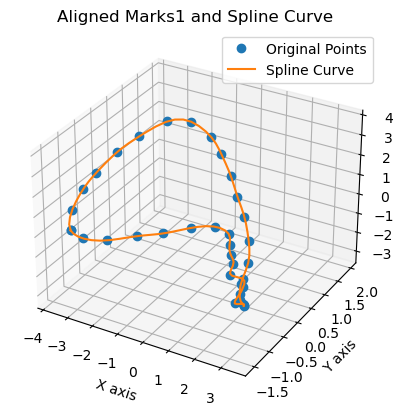

In [12]:
mark_file_path1 = "150颗0806新数据/1.obj.mark"
mark_encoding1 = detect_encoding(mark_file_path1)
marks1 = load_mark_file(mark_file_path1, mark_encoding1)
aligned_marks1 = np.asarray(marks1).dot(final_rotation_matrix)
spline_points1 = interpolate_spline(aligned_marks1)

In [13]:
import csv

def load_csv_file(csv_file_path):
    '''读取csv文件，对应marks2的数据'''
    # 检查文件是否存在
    if not os.path.exists(csv_file_path):
        raise FileNotFoundError(f"The file {csv_file_path} does not exist.")
    
    # 初始化节点和边数据
    marks2_temp = []
    G2 = nx.Graph()  # Graph是单向图且自带同向、逆向去重，每两节点间最多只有一条边

    # 读取csv文件
    with open(csv_file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # 跳过标题行
        for row in reader:
            data_type = row[0]
            if data_type == 'node':
                i, x, y, z, color = int(row[1]), float(row[3]), float(row[4]), float(row[5]), row[6]
                marks2_temp.append([x, y, z])
            elif data_type == 'edge':
                source, target, color = int(row[1]), int(row[2]), row[6]
                G2.add_edge(source, target)

    marks2 = np.array(marks2_temp)  # 不能在这一步去除孤立点因为这会改变marks2的index;不过不要紧,后续计算节点间路径的环节仍然能起到删除孤立点的作用
    
    # 返回处理后的数据
    return marks2, G2

def find_intersections_and_paths(G2):
    """
    找到 G2 中的节点，并确定节点间的路径。
    如果一条路径能够分解为几条更短的路径（即路径上通过其他节点），那么只储存更短的路径。
    
    参数:
    G2: networkx 图，包含图的边信息。
    
    返回:
    filtered_paths: 路径列表。
    intersections: 节点的列表。
    """
    # 识别 G2 中度大于2的点作为节点
    intersections = [node for node, degree in dict(G2.degree()).items() if degree > 2]

    # 初始化原子路径
    filtered_paths = []

    # 遍历所有节点对
    for i in range(len(intersections)):
        for j in range(i + 1, len(intersections)):
            node1 = intersections[i]
            node2 = intersections[j]

            # 找到两个节点之间的一条最短路径
            shortest_path = nx.shortest_path(G2, source=node1, target=node2)

            # 路径中的中间节点是否包含第三个或更多节点
            intermediate_nodes = shortest_path[1:-1]
            if any(node in intersections for node in intermediate_nodes):
                continue  # 如果包含第三个或更多节点，跳过此路径
            else:
                filtered_paths.append(shortest_path)  # 将路径添加到 paths 列表中
    
    return filtered_paths, intersections

def interpolate_spline_open_path(path, mark_points):
    """
    对给定的路径进行插值。如果路径长度大于3，使用三阶样条插值；否则使用线性插值。
    
    参数:
    path: 要插值的路径，节点的列表。
    mark_points: 对应 G2 中各点坐标。
    
    返回:
    spline_points: 插值后的点的坐标。
    """
    # 提取路径上的点
    ordered_marks = np.array([mark_points[i] for i in path])
    
    # 提取 x, y, z 坐标
    x = ordered_marks[:, 0]
    y = ordered_marks[:, 1]
    z = ordered_marks[:, 2]
    
    if len(path) > 3:
        # 对于长度大于3的路径，进行三阶样条插值
        t = np.linspace(0, 1, len(path))
        spline_x = make_interp_spline(t, x, k=3)
        spline_y = make_interp_spline(t, y, k=3)
        spline_z = make_interp_spline(t, z, k=3)
        # 插值点数 100
        t_new = np.linspace(0, 1, 100)
        spline_x_new = spline_x(t_new)
        spline_y_new = spline_y(t_new)
        spline_z_new = spline_z(t_new)
        
    else:
        # 对于长度小于等于3的路径，进行线性插值，插值点数 10
        t_new = np.linspace(0, 1, 10)
        spline_x_new = np.interp(t_new, [0, 1], [x[0], x[-1]])
        spline_y_new = np.interp(t_new, [0, 1], [y[0], y[-1]])
        spline_z_new = np.interp(t_new, [0, 1], [z[0], z[-1]])
    
    return np.vstack([spline_x_new, spline_y_new, spline_z_new]).T

def plot_paths_3d(paths, aligned_marks2):
    """
    绘制所有路径的3D图。
    
    参数:
    paths: 路径列表，每个路径包含插值后的点。
    aligned_marks2: 对应 G2 图中节点的位置。
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 绘制每条路径
    for path in paths:
        ax.plot(path[:, 0], path[:, 1], path[:, 2], '-')
    
    # 绘制marks点
    ax.scatter(aligned_marks2[:, 0], aligned_marks2[:, 1], aligned_marks2[:, 2], c='r', marker='o')

    ax.set_title('Aligned Marks2 and Spline Curve')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # 设置视角
    # ax.view_init(elev=0, azim=0)
    
    plt.show()


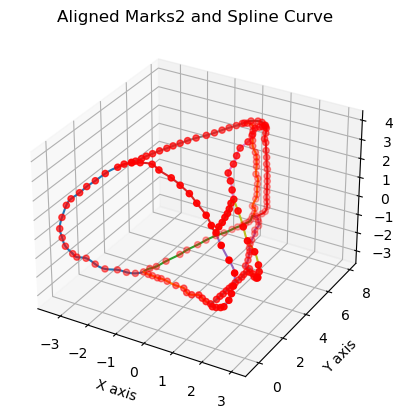

In [14]:
mark_file_path2 = "多分类_0819/1.csv"
aligned_marks2, G2 = load_csv_file(mark_file_path2)
paths, intersections = find_intersections_and_paths(G2)

# 对所有路径进行插值
interpolated_paths = []
for path in paths:
    interpolated_paths.append(interpolate_spline_open_path(path, aligned_marks2))

# 绘制插值后的路径
plot_paths_3d(interpolated_paths, aligned_marks2)

# 插值线上的所有点
spline_points2 = np.unique(np.vstack(interpolated_paths), axis=0)

In [15]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree

def find_nearby_points(vertices, curve_points, tolerance):
    """
    在曲线附近找到宽度为 tolerance 的点。
    
    参数:
    vertices: 点云数据。
    curve_points: 样条插值生成的曲线点。
    tolerance: 宽度容忍度。
    
    返回:
    nearby_points_indices: 在曲线附近的点的索引。
    """
    # 使用 KDTree 查找邻域
    tree = cKDTree(vertices)
    nearby_points_indices = set()
    
    for point in curve_points:
        indices = tree.query_ball_point(point, tolerance)
        nearby_points_indices.update(indices)
    
    return nearby_points_indices

def generate_graph(vertices, faces):
    """
    生成点云的拓扑图。
    """
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i + 1) % len(face)])
    return G

def segment_point_cloud(vertices, faces, spline_points):
    """
    执行点云分割。通过逐步增加tolerance的方式移除spline_points附近的点，直到图被分割为8个大块。
    """
    G = generate_graph(vertices, faces)  # 生成拓扑图

    tolerance = 0.1
    while tolerance <= 1.0:
        nearby_points = find_nearby_points(vertices, spline_points, tolerance)
        G.remove_nodes_from(nearby_points)
        components = list(nx.connected_components(G))
        large_components = [comp for comp in components if len(comp) > 20]  # 规定大于20个点的组件才能被视为真正的组件

        if len(large_components) == 8:
            print(f"分割成功，容差为：{tolerance}")
            
            # y 均值最大和最小的分别是切端和牙根
            sorted_components = sorted(large_components, key=lambda comp: np.mean([vertices[i][1] for i in comp]))
            part1 = sorted_components[0]  # 牙根
            part2 = sorted_components[-1]  # 切端

            # 剩下部分中 z 均值最大和最小的分别是远中和近中
            remaining_parts = sorted_components[1:-1]
            remaining_parts.sort(key=lambda comp: np.mean([vertices[i][2] for i in comp]))
            part3 = remaining_parts[0]  # 近中
            part4 = remaining_parts[-1]  # 远中

            # 剩下部分中 x 均值最大和最小的分别是舌轴面和唇面
            remaining_parts = remaining_parts[1:-1]
            remaining_parts.sort(key=lambda comp: np.mean([vertices[i][0] for i in comp]))
            part5 = remaining_parts[-1]  # 舌轴面
            part6 = remaining_parts[0]  # 唇面

            # 剩下部分中 y 均值较大的是舌面凹，较小的是肩台
            remaining_parts = remaining_parts[1:-1]
            remaining_parts.sort(key=lambda comp: np.mean([vertices[i][1] for i in comp]))
            part7 = remaining_parts[0]  # 肩台
            part8 = remaining_parts[1]  # 舌面窝

            return [part1, part2, part3, part4, part5, part6, part7, part8], nearby_points

        tolerance += 0.02

    print(f"分割失败，组件数：{len(large_components)}")
    return [], nearby_points

def perform_voting(vertices, parts):
    """
    为点云数据中的每个点分配标签，确保每个 part 的标签与其索引一致，同时使用投票机制对未标记的点进行标签分配。
    
    参数:
    vertices: 点云数据，形状为 (n, 3)，每行表示一个点的 (x, y, z) 坐标。
    parts: 列表，包含每个分区的点的索引列表。
    
    返回:
    labels: 点的标签，形状为 (n,)，每个标签是一个整数。
    """
    # 创建 KDTree 以高效地查找邻域
    tree = KDTree(vertices)
    
    # 创建标签数组
    labels = np.zeros(len(vertices), dtype=int)
    
    # 为每个 part 分配标签
    for i, part in enumerate(parts):
        for idx in part:
            labels[idx] = i + 1  # 标签从1开始
    
    # 临时标签数组用于存储投票结果
    temp_labels = np.zeros(len(vertices), dtype=int)
    
    # 设置邻域半径的初始值和最大值
    r_min = 0.2
    r_max = 1
    r_increment = 0.2
    
    # 对每个未标记的点进行投票
    for i, vertex in enumerate(vertices):
        if labels[i] > 0:
            continue  # 跳过已经标记的点
        
        # 初始化邻域半径
        r = r_min
        found_valid_neighbor = False
        
        while r <= r_max:
            # 查找邻居
            neighbors, distances = tree.query_radius([vertex], r=r, return_distance=True)
            neighbors = neighbors[0]  # 提取索引数组
            distances = distances[0]  # 提取距离数组
            
            # 只考虑已标记的邻居进行投票
            valid_neighbors = neighbors[labels[neighbors] > 0]
            valid_distances = distances[labels[neighbors] > 0]
            
            if len(valid_neighbors) > 2:  # 确保有足够的有效邻居
                found_valid_neighbor = True
                break
            r += r_increment
        
        if not found_valid_neighbor:
            continue

        # 如果找到有效邻居，进行标签投票
        neighbor_labels = labels[valid_neighbors]
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        
        if len(unique_labels) > 0:
            # 获取最高计数的标签
            max_count = np.max(counts)
            candidates = unique_labels[counts == max_count]
            
            if len(candidates) > 1:  # 如果有多个标签计数相同，选择平均距离最小的标签
                avg_distances = np.array([np.mean(valid_distances[neighbor_labels == label]) for label in candidates])
                best_label = candidates[np.argmin(avg_distances)]
            else:
                best_label = candidates[0]
            
            temp_labels[i] = best_label
    
    # 更新最终标签
    labels[temp_labels > 0] = temp_labels[temp_labels > 0]
    
    return labels

def save_labeled_point_cloud(vertices, labels, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for i, vertex in enumerate(vertices):
            if labels[i] > 0:  # 仅保存已标记的点
                file.write(f"{vertex[0]} {vertex[1]} {vertex[2]} {labels[i]}\n")


In [16]:
# 合并所有插值点为一个数据,即完整轮廓线
spline_points = np.unique(np.vstack([spline_points1, spline_points2]), axis=0)

# 执行点云分割和标签分配
parts, points_to_remove = segment_point_cloud(aligned_points, obj_faces, spline_points)
labels = perform_voting(aligned_points, parts)

# save_labeled_point_cloud(aligned_points, labels, 'output.txt')


分割失败，组件数：3


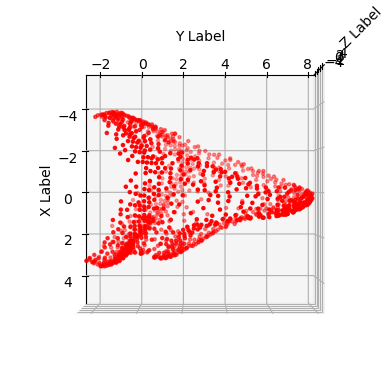

In [17]:
# 提取被删除点的坐标
removed_points = np.array([aligned_points[i] for i in points_to_remove])

# 绘制这些点
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(removed_points[:, 0], removed_points[:, 1], removed_points[:, 2], c='r', marker='.')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# 保持原始点云各轴比例一致
max_range = np.array([removed_points[:, 0].max() - removed_points[:, 0].min(),
                      removed_points[:, 1].max() - removed_points[:, 1].min(),
                      removed_points[:, 2].max() - removed_points[:, 2].min()]).max() / 2.0

mid_x = (removed_points[:, 0].max() + removed_points[:, 0].min()) * 0.5
mid_y = (removed_points[:, 1].max() + removed_points[:, 1].min()) * 0.5
mid_z = (removed_points[:, 2].max() + removed_points[:, 2].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# 设置视角
ax.view_init(elev=90, azim=0)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


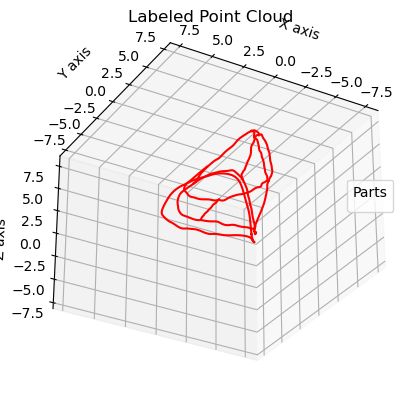

In [18]:
def plot_labeled_point_cloud(vertices, labels, spline_points1, interpolated_paths, point_size=1, colors_list=None, labels_list=None, alpha_list=None):
    """
    绘制带有不同颜色标签的点云图。

    参数:
    vertices: 点云数据，形状为 (n, 3)，每行表示一个点的 (x, y, z) 坐标。
    labels: 点的标签，形状为 (n,)，每个标签是一个整数。
    colors_list: 每个标签的颜色列表，形状为 (m,)。
    labels_list: 每个标签的图例标签列表，形状为 (m,)。
    """
    # 创建 3D 图形
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 获取唯一的标签
    unique_labels = np.unique(labels)
    
    # 设置颜色映射
    if colors_list is None:
        colors_list = plt.cm.get_cmap('tab10', len(unique_labels))  # 默认使用 tab10 colormap
    
    # 设置图例标签
    if labels_list is None:
        labels_list = [f'Label {label}' for label in unique_labels]

    # 设置透明度列表
    if alpha_list is None:
        alpha_list = [0.5] * len(unique_labels)  # 默认透明度为 0.5

    # 绘制每个标签的点
    for label in unique_labels:
        if label == 0:
            continue  # 跳过未标记的点

        # 获取当前标签的点
        indices = np.where(labels == label)[0]
        points = vertices[indices]

        # 使用列表中的信息
        color = colors_list[int(label) - 1] if colors_list else 'gray'
        get_label = labels_list[int(label)-1] if labels_list else 'unknown'
        alpha = alpha_list[int(label) - 1] if alpha_list else 0.5
        
        # 绘制点
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=color, label=get_label, alpha=alpha, s=point_size)

    # 绘制marks1线
    ax.plot(spline_points1[:, 0], spline_points1[:, 1], spline_points1[:, 2], '-', color='red')
    
    # 绘制marks2线
    for path in interpolated_paths:
        ax.plot(path[:, 0], path[:, 1], path[:, 2], '-', color='red')

    # 设置图例和标签
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend(loc='center left', bbox_to_anchor=(0.85, 0.55), title='Parts')
    plt.title('Labeled Point Cloud')

    # 保持原始点云各轴比例一致
    points = np.asarray(vertices)
    max_range = np.array([points[:, 0].max() - points[:, 0].min(),
                          points[:, 1].max() - points[:, 1].min(),
                          points[:, 2].max() - points[:, 2].min()]).max() / 2.0

    mid_x = (points[:, 0].max() + points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max() + points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max() + points[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # 设置视角
    ax.view_init(elev=-30, azim=60)
    
    plt.show()



# 自定义颜色列表
colors_list = ['gray', 'pink', 'gray', 'gray', 'green', 'blue', 'pink', 'blue']

# 自定义标签列表
# labels_list = ['牙根', '切端', '近中', '远中', '舌轴面', '唇面', '肩台', '舌面窝']
labels_list = ['Ya Gen', 'Qie Duan', 'Jin Zhong', 'Yuan Zhong', 'She Zhou Mian', 'Chun Mian', 'Jian Tai', 'She Mian Wo']

# 自定义透明度列表
alpha_list = [1.0, 1.0, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5]

# 自定义点的大小
point_size = 0.1

plot_labeled_point_cloud(aligned_points, labels, spline_points1, interpolated_paths, point_size, colors_list=colors_list, labels_list=labels_list, alpha_list=alpha_list)



In [19]:
'''
4.多分类PointNet++模型
'''


'\n4.多分类PointNet++模型\n'

In [20]:
'''
5.轮廓线重建
'''


'\n5.轮廓线重建\n'